In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, DataCollatorWithPadding

from transformers import TrainingArguments, Trainer
from datasets import Dataset
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

/Users/stephentoner/miniconda3/envs/SI699proj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps:0")

In [7]:
ds_train = Dataset.from_csv('train_twitter.csv')
ds_val = Dataset.from_csv('validate_twitter.csv')
ds_test = Dataset.from_csv('test_twitter.csv')
print(ds_test)
ds_test_viz = ds_test.filter(lambda ex: ex['country'] == 4)

ds = {"train": ds_train, "validation": ds_val, "test": ds_test, "test_viz": ds_test_viz}

Found cached dataset csv (/Users/stephentoner/.cache/huggingface/datasets/csv/default-2db754ff7953f4a8/0.0.0)
Found cached dataset csv (/Users/stephentoner/.cache/huggingface/datasets/csv/default-c1d4626ff04165b1/0.0.0)
Found cached dataset csv (/Users/stephentoner/.cache/huggingface/datasets/csv/default-7083c7f65e06db68/0.0.0)


Dataset({
    features: ['user_id', 'tweet_id', 'tweet_text', 'country'],
    num_rows: 1000
})


In [8]:
id2label = {0: "United States", 1: "United Kingdom", 2: "Canada", 3: "Australia", 4: "India", 5: "Nigeria"}
label2id = {"United States": 0, "United Kingdom": 1, "Canada": 2, "Australia": 3, "India": 4, "Nigeria": 5}

In [9]:
ds_test


Dataset({
    features: ['user_id', 'tweet_id', 'tweet_text', 'country'],
    num_rows: 1000
})

In [10]:
model_path = 'my_awesome_model'

model = AutoModelForSequenceClassification.from_pretrained("Twitter/twhin-bert-base", num_labels=6, id2label=id2label, label2id=label2id)
model = model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

def preprocess_function(examples):
    label = examples["country"] 
    examples = tokenizer(examples["tweet_text"], truncation=True, padding="max_length", max_length=256, return_tensors='pt')
    for key in examples:
        examples[key] = examples[key].squeeze(0)
    examples["label"] = label
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=['user_id', 'tweet_id', 'tweet_text', 'country'])
    ds[split].set_format('pt')

Some weights of the model checkpoint at Twitter/twhin-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-ba

In [11]:
ds['test_viz']

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 32
})

In [14]:
len(ds_test_viz)
len(ds['test_viz'])

32

In [12]:
ds['test_viz'] = ds['test_viz'].filter(lambda ex: ex['label'].item() == 4)
ds_test_viz = ds_test_viz.filter(lambda ex: ex['label'].item() == 4)

KeyError: 'label'

In [15]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels), "f1":f1_metric.compute(predictions=predictions, references=labels, average="weighted")}

In [16]:
import torch
class TwitterTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # print ("inputs: ", inputs)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [17]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = TwitterTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)


In [18]:
device

device(type='cpu')

In [19]:
def forward_func(inputs, position = 0):
    """
        Wrapper around prediction method of pipeline
    """
    pred = model(inputs, attention_mask=torch.ones_like(inputs).to(device))
    return pred[position]
    
def visualize(inputs: list, attributes: list):
    """
        Visualization method.
        Takes list of inputs and correspondent attributs for them to visualize in a barplot
    """
    attr_sum = attributes.sum(-1) 
    
    attr = attr_sum / torch.norm(attr_sum)
    
    a = pd.Series(attr.numpy()[0], 
                        index = tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]))
    
    plt.show(a.plot.barh(figsize=(10,20)))
                    
def explain(text: str):
    """
        Main entry method. Passes text through series of transformations and through the model. 
        Calls visualization method.
    """
    prediction = trainer.predict(text)
    inputs = generate_inputs(text)
    baseline = generate_baseline(sequence_len = inputs.shape[1])
    
    lig = LayerIntegratedGradients(forward_func, getattr(model, 'Twitter/twhin-bert-base').embeddings)
    
    attributes, delta = lig.attribute(inputs=inputs,
                                baselines=baseline,
                                target = model.config.label2id[prediction[0]['label']], 
                                return_convergence_delta = True)
    
    visualize(inputs, attributes, prediction)
    
def generate_inputs(text: str):
    """
        Convenience method for generation of input ids as list of torch tensors
    """
    return tokenizer.encode(text, truncation=True, max_length=256, return_tensors='pt').to(device)

def generate_baseline(sequence_len: int):
    """
        Convenience method for generation of baseline vector as list of torch tensors
    """        
    return torch.tensor([tokenizer.cls_token_id] + [tokenizer.pad_token_id] * (sequence_len - 2) + [tokenizer.sep_token_id], device = device).unsqueeze(0)




In [193]:
ds['test_viz']

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 32
})

In [25]:
factory = iter(ds['test_viz'])
text = iter(ds_test_viz)

In [196]:
# tokenizer.decode(example['input_ids'])

'<s> @Eniledamstupid not exorbitantly but a consistent $1 per drink which i respect</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

@Civilerbala1979 @tbstamilnadu @thenisiraj @Thesun01thesun @TamilRatsaschi @Stalinkumari @PATHMARAGAM19 @Pugal0405gmail4 @Hereprak


100%|██████████| 1/1 [00:00<00:00, 25.82it/s]


India


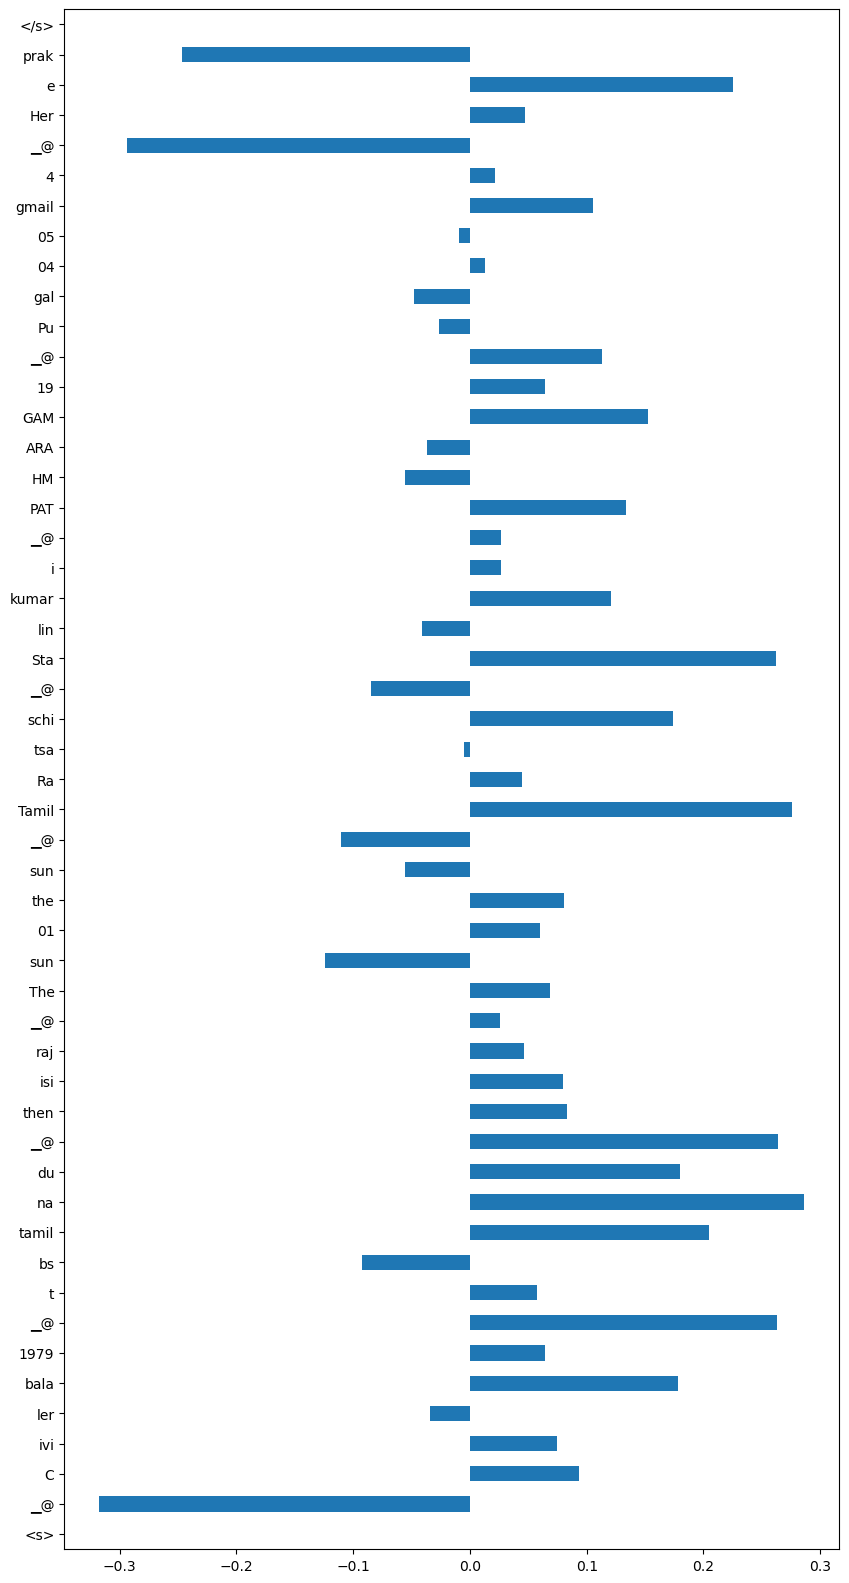

In [32]:
example = next(factory)
example_text = next(text)
print(example_text['tweet_text'])


prediction = trainer.predict([example])

label = model.config.id2label[prediction.label_ids[0]]
print(label)

inputs = generate_inputs(example_text['tweet_text'])
baseline = generate_baseline(sequence_len = inputs.shape[1])
lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)
attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = model.config.label2id[model.config.id2label[prediction.label_ids[0]]], 
                            return_convergence_delta = True)
visualize(inputs, attributes)



In [137]:
attr = attributes.sum(dim=2).squeeze(0)
attr = attr / torch.norm(attr)
attr = attr.cpu().detach().numpy()

AttributeError: 'BertForSequenceClassification' object has no attribute 'Twitter/twhin-bert-base'

In [ ]:
rec = viz.VisualizationDataRecord(attr, 
                            .9,
                            model.config.label2id[model.config.id2label[prediction.label_ids[0]]],
                            0,
                            id2label[0],
                            attributes.sum(),
                            tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]),
                            delta)

In [ ]:
tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0])

In [ ]:
viz.visualize_text([rec])

In [ ]:

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence


# Below we define a set of helper function for constructing references / baselines for word tokens, token types and position ids. We also provide separate helper functions that allow to construct attention masks and bert embeddings both for input and reference.

# In[7]:


def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] +         [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids,                                     token_type_ids=None, ref_token_type_ids=None,                                     position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings


# Let's define the `question - text` pair that we'd like to use as an input for our Bert model and interpret what the model was forcusing on when predicting an answer to the question from given input text 

# In[8]:


question, text = "What is important to us?", "It is important to us to include, empower and support humans of all kinds."


# Let's numericalize the question, the input text and generate corresponding baselines / references for all three sub-embeddings (word, token type and position embeddings) types using our helper functions defined above.

# In[9]:


input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

In [ ]:



def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


# In[14]:


attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)


# In[15]:


# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_start_sum.sum(),       
                        all_tokens,
                        delta_start)

end_position_vis = viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        torch.argmax(end_scores),
                        str(ground_truth_end_ind),
                        attributions_end_sum.sum(),       
                        all_tokens,
                        delta_end)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

print('\033[1m', 'Visualizations For End Position', '\033[0m')
viz.visualize_text([end_position_vis])